# Testing some Whitebox models

We mentionned in class 5 whitebox models easily interpretable. We can test each of them on our dataset : 
1. Linear Regression (OLS)
2. Logistic Regression (LR)
3. Decision Tree (DT)
4. Logistic Tree Regression (PLTR) 

We also studied the GAN but it only applies for Regression cases.

In [18]:
# Import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [19]:
cd ..

/Users/vitrac/Desktop/M2 HEC/14 - Algorithm Fairness


In [3]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Loading the dataset 
df = pd.read_csv('Dataset/df_processed.csv')

# One-hot encoding of categorical columns
columns_to_encode = ["Gender", "EthnicGroup", "WklyStudyHours", "ParentEduc", "LunchType", "ParentMaritalStatus", "PracticeSport"]
df_encoded = pd.get_dummies(df, columns=columns_to_encode)

# Split the dataset
X = df_encoded.drop('Grade', axis=1).copy()
y = df_encoded['Grade'].copy()

# Create train, test, and validation data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [5]:
# Empty dataframe to store the results of our whitebox models
df_whitebox_results = pd.DataFrame(columns=['Model name', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'])

## 01 - OLS

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Fit and predict with a linear regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_val_continuous = linear_reg.predict(X_val)
threshold = 0.5
y_val_pred_binary = (y_val_continuous > threshold).astype(int)

# Calculate evaluation metrics for classification
accuracy = accuracy_score(y_val, y_val_pred_binary)
precision = precision_score(y_val, y_val_pred_binary)
recall = recall_score(y_val, y_val_pred_binary)
f1 = f1_score(y_val, y_val_pred_binary)
roc_auc = roc_auc_score(y_val, y_val_continuous)

# Append the results to df_whitebox_results
results_dict_ols = {
    'Model name': ['OLS'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC-ROC': [roc_auc]
}

results_df_ols = pd.DataFrame(results_dict_ols)
df_whitebox_results = pd.concat([df_whitebox_results, results_df_ols], ignore_index=True)

## 02 - Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Fit a logistic regression model
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)
y_val_probabilities = logistic_reg.predict_proba(X_val)[:, 1]
threshold = 0.5
y_val_pred_binary = (y_val_probabilities > threshold).astype(int)

# Calculate evaluation metrics for classification
accuracy = accuracy_score(y_val, y_val_pred_binary)
precision = precision_score(y_val, y_val_pred_binary)
recall = recall_score(y_val, y_val_pred_binary)
f1 = f1_score(y_val, y_val_pred_binary)
roc_auc = roc_auc_score(y_val, y_val_probabilities)

# Append the results to df_whitebox_results
results_dict_logistic = {
    'Model name': ['Logistic Regression'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC-ROC': [roc_auc]
}

results_df_logistic = pd.DataFrame(results_dict_logistic)
df_whitebox_results = pd.concat([df_whitebox_results, results_df_logistic], ignore_index=True)

## 03 - Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Fit and predict with a Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
y_val_pred_binary = decision_tree.predict(X_val)

# Calculate evaluation metrics for classification
accuracy = accuracy_score(y_val, y_val_pred_binary)
precision = precision_score(y_val, y_val_pred_binary)
recall = recall_score(y_val, y_val_pred_binary)
f1 = f1_score(y_val, y_val_pred_binary)
roc_auc = roc_auc_score(y_val, y_val_pred_binary)  # If using probabilities, you can calculate AUC-ROC

# Append the results to df_whitebox_results
results_dict_dt = {
    'Model name': ['Decision Tree'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC-ROC': [roc_auc]
}

results_df_dt = pd.DataFrame(results_dict_dt)
df_whitebox_results = pd.concat([df_whitebox_results, results_df_dt], ignore_index=True)

## 04 - PLTR

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Create polynomial features
poly = PolynomialFeatures(degree=2)  # Choisir le degré souhaité
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)

# Fit a Polynomial Logistic Regression model
pltr = LogisticRegression()
pltr.fit(X_train_poly, y_train)
y_val_probabilities = pltr.predict_proba(X_val_poly)[:, 1]
threshold = 0.5
y_val_pred_binary = (y_val_probabilities > threshold).astype(int)

# Calculate evaluation metrics for classification
accuracy = accuracy_score(y_val, y_val_pred_binary)
precision = precision_score(y_val, y_val_pred_binary)
recall = recall_score(y_val, y_val_pred_binary)
f1 = f1_score(y_val, y_val_pred_binary)
roc_auc = roc_auc_score(y_val, y_val_probabilities)

# Append the results to df_whitebox_results for Polynomial Logistic Regression (PLTR)
results_dict_pltr = {
    'Model name': ['Polynomial Logistic Regression'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC-ROC': [roc_auc]
}

results_df_pltr = pd.DataFrame(results_dict_pltr)
df_whitebox_results = pd.concat([df_whitebox_results, results_df_pltr], ignore_index=True)

/Users/vitrac/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Results Analysis 

In [10]:
df_whitebox_results

,Model name,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,OLS,0.771105,0.627660,0.157473,0.251778,0.758729
1,Logistic Regression,0.773934,0.600950,0.225089,0.327508,0.758530
2,Decision Tree,0.681897,0.337500,0.312278,0.324399,0.556916
3,Polynomial Logistic Regression (PLTR),0.770235,0.584158,0.209964,0.308901,0.754067


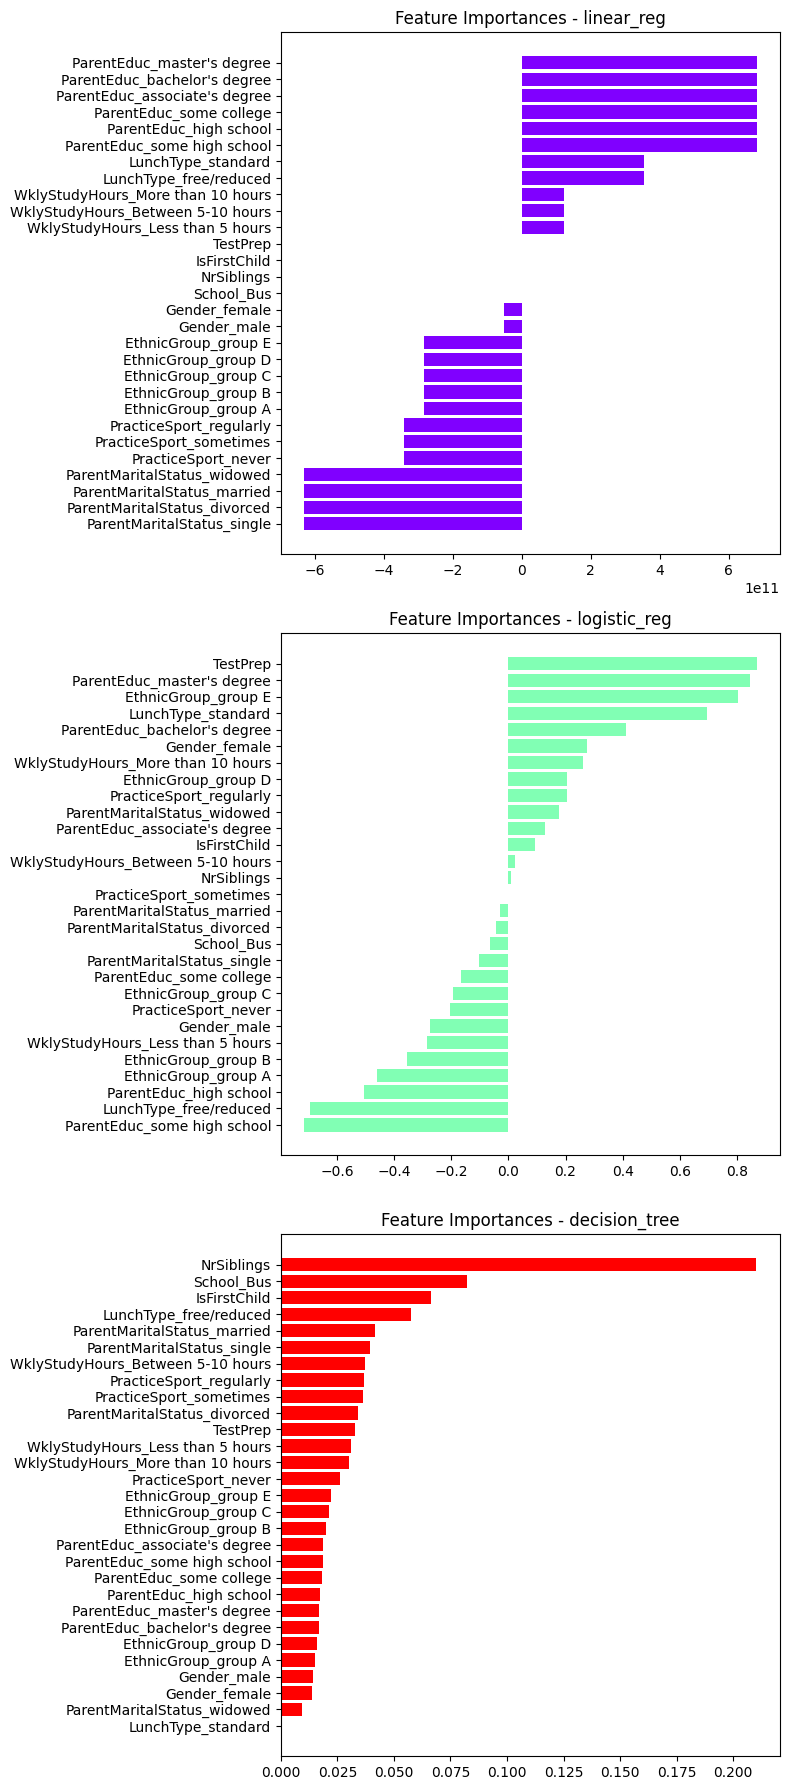

In [17]:
# Feature importances for the first three models
feature_importances = {
    'linear_reg': linear_reg.coef_,
    'logistic_reg': logistic_reg.coef_[0],
    'decision_tree': decision_tree.feature_importances_
}

models = list(feature_importances.keys())
colors = plt.get_cmap('rainbow')(np.linspace(0, 1, len(models)))

fig, axes = plt.subplots(len(models), 1, figsize=(8, 6 * len(models)))

for i, model in enumerate(models):
    importances = feature_importances[model]
    indices = np.argsort(importances)

    ax = axes[i]
    ax.barh(range(len(importances)), importances[indices], color=colors[i])
    ax.set(yticks=range(len(importances)), yticklabels=np.array(X_train.columns)[indices])
    ax.set_title(f'Feature Importances - {model}')

plt.tight_layout()
plt.show()
